In [1]:
from priors import *
from plots import *
from functions import *

xp = gwpop.cupy_utils.xp

In [2]:
luminosity_distances = np.linspace(1, 50000, 1000)
redshifts = np.array([cosmo.z_at_value(Planck15.luminosity_distance, 
                                                   dl * u.Mpc) for dl in luminosity_distances])
dl_to_z = interp1d(luminosity_distances, redshifts)
luminosity_prior = luminosity_distances ** 2
dz_ddl = np.gradient(redshifts, luminosity_distances)

redshift_prior = interp1d(redshifts, luminosity_prior / dz_ddl / (1 + redshifts))

### Posteriors

In [3]:
## Only run this to load posteriors if they have already been calculated

posteriors = list()
for filename in glob.glob('../processed_samples/OverallPosteriors/*'):
    _posterior = pd.read_csv(filename)
    posteriors.append(_posterior)

In [4]:
# Sampling pdfs

for posterior in posteriors:
    
    # Joint prior for chi_eff and chi_p is posterior["joint_prior"]
    
    # Mass prior 
    PRIOR_VOLUME = (100. - 2.) ** 2 /2
    posterior["mass_prior"] = (posterior["mass_1"] * (1+posterior["redshift"])**2)/PRIOR_VOLUME
    
    # Redshift prior
    posterior["redshift_prior"] = redshift_prior(posterior['redshift'])

### Spin Gaussian model with spin selection effects

In [5]:
model = bilby.hyper.model.Model([spin.GaussianChiEffChiP()])

for posterior in posteriors:
    posterior["prior"] = posterior["joint_prior"]

In [6]:
def load_vt():
    vt_file = '../Sensitivity/O3aSensitivity/o3a_bbhpop_inj_info.hdf'
    vt_model = Model([spin.gaussian_chi_eff])
    vt_func = injection_resampling_vt_spin
    
    return vt_func(vt_file, model = vt_model)

selection_function = load_vt()

10:02 bilby INFO    : Loading VT data from ../Sensitivity/O3aSensitivity/o3a_bbhpop_inj_info.hdf.


In [7]:
priors = PriorDict()

# spin
priors["mu_chi_eff"] = Uniform(minimum = -1, maximum = 1, latex_label =r'$\mu_\mathrm{eff}$')
priors["sigma_chi_eff"] = Uniform(minimum = 0.01, maximum = 1, latex_label =r'$\sigma_\mathrm{eff}$')
priors["mu_chi_p"] = Uniform(minimum = 0.01, maximum = 1, latex_label =r'$\mu_\mathrm{p}$')
priors["sigma_chi_p"] = Uniform(minimum = 0.01, maximum = 1, latex_label =r'$\sigma_\mathrm{p}$')
priors["spin_covariance"] = Uniform(minimum = -0.5, maximum = 0.5, latex_label =r'$\rho$')

In [8]:
likelihood = gwpop.hyperpe.HyperparameterLikelihood(posteriors = posteriors, 
                                                    hyper_prior = model,
                                                    selection_function = selection_function)

In [9]:
likelihood.parameters.update(priors.sample())

In [10]:
result = bilby.run_sampler(likelihood = likelihood, priors = priors, sampler='dynesty',
                           nlive = 1000, label = "gaussian_spin_vt_spin", 
                           outdir = "Results/gaussian_spin_vt_spin", clean = True)

10:02 bilby INFO    : Running for label 'gaussian_spin_vt_spin', output will be saved to 'Results/gaussian_spin_vt_spin'
10:02 bilby INFO    : Search parameters:
10:02 bilby INFO    :   mu_chi_eff = Uniform(minimum=-1, maximum=1, name=None, latex_label='$\\mu_\\mathrm{eff}$', unit=None, boundary=None)
10:02 bilby INFO    :   sigma_chi_eff = Uniform(minimum=0.01, maximum=1, name=None, latex_label='$\\sigma_\\mathrm{eff}$', unit=None, boundary=None)
10:02 bilby INFO    :   mu_chi_p = Uniform(minimum=0.01, maximum=1, name=None, latex_label='$\\mu_\\mathrm{p}$', unit=None, boundary=None)
10:02 bilby INFO    :   sigma_chi_p = Uniform(minimum=0.01, maximum=1, name=None, latex_label='$\\sigma_\\mathrm{p}$', unit=None, boundary=None)
10:02 bilby INFO    :   spin_covariance = Uniform(minimum=-0.5, maximum=0.5, name=None, latex_label='$\\rho$', unit=None, boundary=None)
10:02 bilby INFO    : Single likelihood evaluation took 5.664e-03 s


0it [00:00, ?it/s]

10:02 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 1000, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 600, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7f04a55f94c0>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
10:02 bilby INFO    : Checkpoint every check_point_delta_t = 600s
10:02 bilby INFO    : Using dynesty version 1.0.1
10:02 bilby INFO    : Using the bilby-implemented rwalk sam

11:17 bilby INFO    : Sampling time: 1:14:17.941145
11:17 bilby INFO    : Summary of results:
nsamples: 13035
ln_noise_evidence:    nan
ln_evidence:    nan +/-  0.125
ln_bayes_factor: 336.718 +/-  0.125



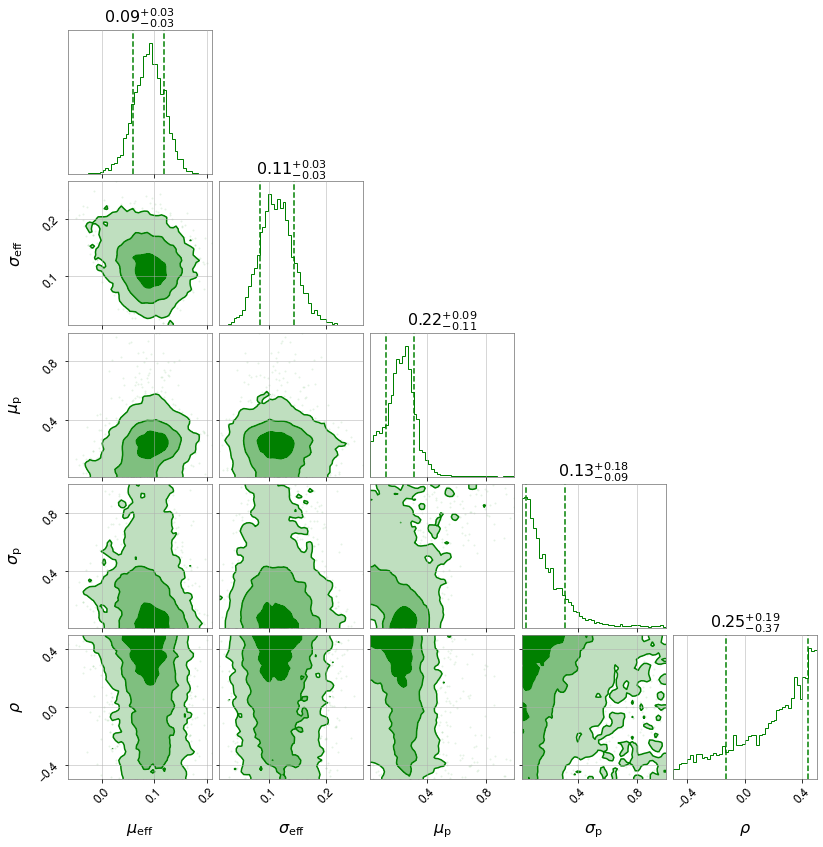

In [11]:
result.plot_corner(color = 'g')

In [ ]:
def overlayed_plot_gaussian(result_O3a_file, result1_file, filename, save = False):
    with open(result_O3a_file,'r') as ff1:
        data1 = json.load(ff1)

    plot_data1 = {
        'mu_eff':{'data':data1['mu_eff'],'plot_bounds':(-0.2,0.2),'priors':(-1.0,1.0),'label':r'$\mu_\mathrm{eff}$'},
        'sigma_eff':{'data':data1['sigma_eff'],'plot_bounds':(0.01,0.3),'priors':(0.01,1.0),'label':r'$\sigma_\mathrm{eff}$'},
        'mu_p':{'data':data1['mu_p'],'plot_bounds':(0.,1.),'priors':(0.,1.0),'label':r'$\mu_p$'},
        'sigma_p':{'data':data1['sigma_p'],'plot_bounds':(0.01,0.5),'priors':(0.01,1.0),'label':r'$\sigma_p$'},
        'corr':{'data':data1['corr'],'plot_bounds':(-0.75,0.75),'priors':(-0.75,0.75),'label':r'$\rho$'}}
    
    with open(result1_file,'r') as ff2:
        data2 = json.load(ff2)

    plot_data2 = {
        'mu_chi_eff':{'data':data2['posterior']['content']['mu_chi_eff'],'plot_bounds':(-0.2,0.2),'priors':(-1.0,1.0),'label':r'$\mu_\mathrm{eff}$'},
        'sigma_chi_eff':{'data':data2['posterior']['content']['sigma_chi_eff'],'plot_bounds':(0.01,0.3),'priors':(0.01,1.0),'label':r'$\sigma_\mathrm{eff}$'},
        'mu_chi_p':{'data':data2['posterior']['content']['mu_chi_p'],'plot_bounds':(0.,1.),'priors':(0.,1.0),'label':r'$\mu_p$'},
        'sigma_chi_p':{'data':data2['posterior']['content']['sigma_chi_p'],'plot_bounds':(0.01,0.5),'priors':(0.01,1.0),'label':r'$\sigma_p$'},
        'spin_covariance':{'data':data2['posterior']['content']['spin_covariance'],'plot_bounds':(-0.5,0.5),'priors':(-0.5,0.5),'label':r'$\rho$'}}
    
    fig = plt.figure(figsize=(8,8))
    plot_corner(fig,plot_data1,"#6a3d9a",bins=25,hist_alpha=0.75)
    plot_corner(fig,plot_data2,"#FF0000",bins=25,hist_alpha=0.75)
    plt.tight_layout()
    fig.subplots_adjust(wspace=0.18, hspace=0.16)
    if save == True:
        filename = ".Results/Overlayed_Plots_Gaussian/" + filename
        fig.savefig(filename, dpi=400)
    plt.show()

mu_eff sigma_eff 0.005995909059666027
mu_eff mu_p 0.010125938517020294
mu_eff sigma_p 0.010941845029423667
mu_eff corr 0.01886645685185602
sigma_eff mu_p 0.013254587669914736
sigma_eff sigma_p 0.01432258787364175
sigma_eff corr 0.024695696694509963
mu_p sigma_p 0.02418809938074594
mu_p corr 0.041706287382803964
sigma_p corr 0.04506680862501764


/home/deepnika.jain/O3a/Gaussian/plots.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))
/home/deepnika.jain/O3a/Gaussian/plots.py:53: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))


mu_chi_eff sigma_chi_eff 0.005193851406903156
mu_chi_eff mu_chi_p 0.00952521075182305
mu_chi_eff sigma_chi_p 0.012047641810106632
mu_chi_eff spin_covariance 0.012667642495596019


/home/deepnika.jain/O3a/Gaussian/plots.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))
/home/deepnika.jain/O3a/Gaussian/plots.py:53: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))


sigma_chi_eff mu_chi_p 0.013151813484325602
sigma_chi_eff sigma_chi_p 0.016634628056094145
sigma_chi_eff spin_covariance 0.01749068610962853


/home/deepnika.jain/O3a/Gaussian/plots.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))
/home/deepnika.jain/O3a/Gaussian/plots.py:53: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))


mu_chi_p sigma_chi_p 0.03050690626264189
mu_chi_p spin_covariance 0.032076865188473455


/home/deepnika.jain/O3a/Gaussian/plots.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))
/home/deepnika.jain/O3a/Gaussian/plots.py:53: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))


sigma_chi_p spin_covariance 0.04057134191050243


/home/deepnika.jain/O3a/Gaussian/plots.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))


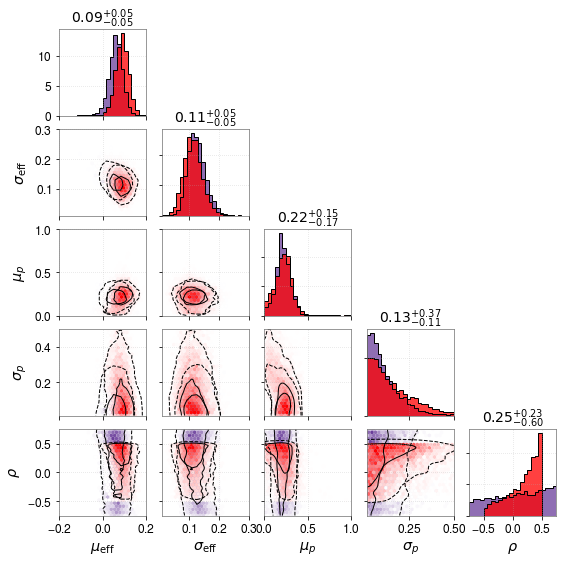

In [12]:
# With spin-covariance prior between (-0.5, 0.5)

overlayed_plot_gaussian("Results/O3a_LIGO_gaussian_results/gaussian-chiEff-chiP-samples.json", 
                        "Results/gaussian_spin_vt_spin/gaussian_spin_vt_spin_result.json", 
                        "spin_vt_spin", save = False)

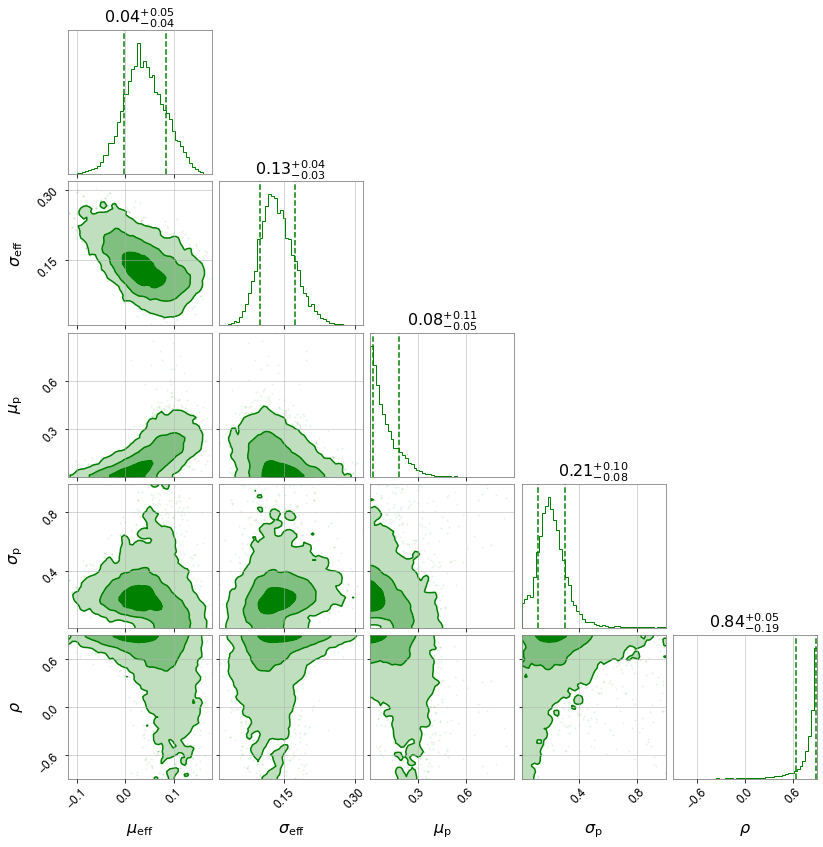

In [11]:
result.plot_corner(color = 'g')

In [12]:
def overlayed_plot_gaussian(result_O3a_file, result1_file, filename, save = False):
    with open(result_O3a_file,'r') as ff1:
        data1 = json.load(ff1)

    plot_data1 = {
        'mu_eff':{'data':data1['mu_eff'],'plot_bounds':(-0.2,0.2),'priors':(-1.0,1.0),'label':r'$\mu_\mathrm{eff}$'},
        'sigma_eff':{'data':data1['sigma_eff'],'plot_bounds':(0.01,0.3),'priors':(0.01,1.0),'label':r'$\sigma_\mathrm{eff}$'},
        'mu_p':{'data':data1['mu_p'],'plot_bounds':(0.,1.),'priors':(0.,1.0),'label':r'$\mu_p$'},
        'sigma_p':{'data':data1['sigma_p'],'plot_bounds':(0.01,0.5),'priors':(0.01,1.0),'label':r'$\sigma_p$'},
        'corr':{'data':data1['corr'],'plot_bounds':(-0.9,0.9),'priors':(-0.75,0.75),'label':r'$\rho$'}}
    
    with open(result1_file,'r') as ff2:
        data2 = json.load(ff2)

    plot_data2 = {
        'mu_chi_eff':{'data':data2['posterior']['content']['mu_chi_eff'],'plot_bounds':(-0.2,0.2),'priors':(-1.0,1.0),'label':r'$\mu_\mathrm{eff}$'},
        'sigma_chi_eff':{'data':data2['posterior']['content']['sigma_chi_eff'],'plot_bounds':(0.01,0.3),'priors':(0.01,1.0),'label':r'$\sigma_\mathrm{eff}$'},
        'mu_chi_p':{'data':data2['posterior']['content']['mu_chi_p'],'plot_bounds':(0.,1.),'priors':(0.,1.0),'label':r'$\mu_p$'},
        'sigma_chi_p':{'data':data2['posterior']['content']['sigma_chi_p'],'plot_bounds':(0.01,0.5),'priors':(0.01,1.0),'label':r'$\sigma_p$'},
        'spin_covariance':{'data':data2['posterior']['content']['spin_covariance'],'plot_bounds':(-0.9,0.9),'priors':(-0.9,0.9),'label':r'$\rho$'}}
    
    fig = plt.figure(figsize=(8,8))
    plot_corner(fig,plot_data1,"#6a3d9a",bins=25,hist_alpha=0.75)
    plot_corner(fig,plot_data2,"#FF0000",bins=25,hist_alpha=0.75)
    plt.tight_layout()
    fig.subplots_adjust(wspace=0.18, hspace=0.16)
    if save == True:
        filename = ".Results/Overlayed_Plots_Gaussian/" + filename
        fig.savefig(filename, dpi=400)
    plt.show()

mu_eff sigma_eff 0.005995909059666027
mu_eff mu_p 0.010125938517020294
mu_eff sigma_p 0.010941845029423667
mu_eff corr 0.01886645685185602
sigma_eff mu_p 0.013254587669914736
sigma_eff sigma_p 0.01432258787364175
sigma_eff corr 0.024695696694509963
mu_p sigma_p 0.02418809938074594
mu_p corr 0.041706287382803964
sigma_p corr 0.04506680862501764


/home/deepnika.jain/O3a/Gaussian/plots.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))
/home/deepnika.jain/O3a/Gaussian/plots.py:53: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))


mu_chi_eff sigma_chi_eff 0.006628718769087753
mu_chi_eff mu_chi_p 0.009773738912363775
mu_chi_eff sigma_chi_p 0.01159041361152229
mu_chi_eff spin_covariance 0.012279828551727974


/home/deepnika.jain/O3a/Gaussian/plots.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))
/home/deepnika.jain/O3a/Gaussian/plots.py:53: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))


sigma_chi_eff mu_chi_p 0.012385919517191533
sigma_chi_eff sigma_chi_p 0.014688128202573082
sigma_chi_eff spin_covariance 0.015561799787204334


/home/deepnika.jain/O3a/Gaussian/plots.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))
/home/deepnika.jain/O3a/Gaussian/plots.py:53: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))


mu_chi_p sigma_chi_p 0.02165696496776146
mu_chi_p spin_covariance 0.022945153267913486


/home/deepnika.jain/O3a/Gaussian/plots.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))
/home/deepnika.jain/O3a/Gaussian/plots.py:53: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))


sigma_chi_p spin_covariance 0.02721003897684138


/home/deepnika.jain/O3a/Gaussian/plots.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))


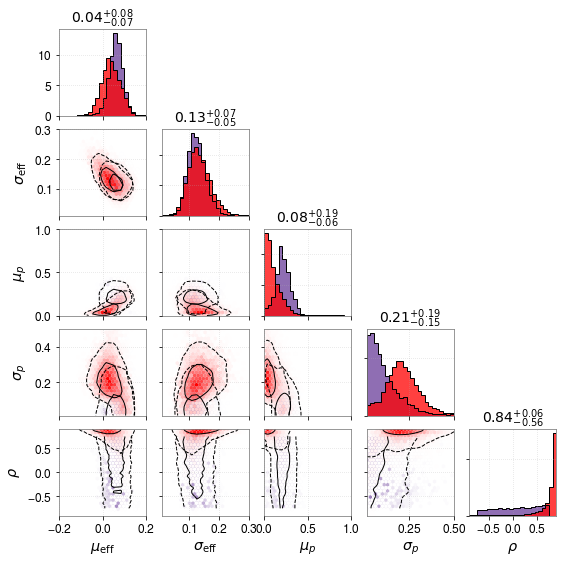

In [13]:
# With spin-covariance prior between (-0.9, 0.9)

overlayed_plot_gaussian("Results/O3a_LIGO_gaussian_results/gaussian-chiEff-chiP-samples.json", 
                        "Results/gaussian_spin_vt_spin/gaussian_spin_vt_spin_result.json", 
                        "spin_vt_spin", save = False)